In [37]:
import numpy as np
import pandas as pd

import sklearn
import lightgbm as lgb
from sklearn.decomposition import PCA

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
train = pd.read_csv("train.csv")

In [55]:
# train.head()
train.iloc[1000:2000:100]
# train.tail()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
1000,45,0,50,28300333.37,1,1.000630,3.158290e+08,NaN,NaN,1.000559,58714.12,1.000630,76390.72,1.000590,0.699758,5,0_50_45
1100,151,0,50,20682383.06,1,1.000277,5.447600e+07,NaN,NaN,1.000097,263229.12,1.000277,58555.20,1.000244,9.950399,5,0_50_151
1200,54,0,60,8799213.11,-1,1.000379,9.100169e+06,NaN,NaN,1.000274,1149.00,1.000588,862.02,1.000453,1.820326,6,0_60_54
1300,162,0,60,2605484.28,1,1.000692,7.457044e+06,NaN,NaN,1.000147,6428.80,1.000746,55137.00,1.000210,-10.920167,6,0_60_162
1400,63,0,70,115717.94,-1,1.000499,2.634561e+06,NaN,NaN,1.000499,25586.07,1.000695,14659.96,1.000624,-6.269813,7,0_70_63
1500,171,0,70,0.00,0,1.000543,1.558816e+07,NaN,NaN,1.000543,52990.83,1.000834,23100.00,1.000746,-4.000068,7,0_70_171
1600,73,0,80,3166940.61,1,1.000239,2.658483e+06,NaN,NaN,0.999833,213727.36,1.000239,4067.25,1.000231,5.710125,8,0_80_73
1700,180,0,80,731572.26,1,1.000827,2.200683e+06,NaN,NaN,1.000472,25114.26,1.000916,22984.68,1.000704,7.209778,8,0_80_180
1800,84,0,90,59616754.18,-1,1.000589,6.271327e+07,NaN,NaN,1.000534,35237.28,1.000951,2711.69,1.000921,-5.779862,9,0_90_84
1900,189,0,90,658129.18,-1,1.002316,3.627697e+06,NaN,NaN,1.002203,266.82,1.002428,21350.40,1.002206,-1.350045,9,0_90_189


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 679.4+ MB


In [6]:
train.describe()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
count,5.237980e+06,5.237980e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237760e+06,2.343638e+06,2.380800e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237892e+06,5.237980e+06
mean,9.928856e+01,2.415100e+02,2.700000e+02,5.715293e+06,-1.189619e-02,9.999955e-01,4.510025e+07,1.001713e+00,9.996601e-01,9.997263e-01,5.181359e+04,1.000264e+00,5.357568e+04,9.999920e-01,-4.756125e-02,1.331005e+04
std,5.787176e+01,1.385319e+02,1.587451e+02,2.051591e+07,8.853374e-01,2.532497e-03,1.398413e+08,7.214705e-01,1.216920e-02,2.499345e-03,1.114214e+05,2.510042e-03,1.293554e+05,2.497509e-03,9.452860e+00,7.619271e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,7.869880e-01,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.852898e+02,0.000000e+00
25%,4.900000e+01,1.220000e+02,1.300000e+02,8.453415e+04,-1.000000e+00,9.987630e-01,5.279575e+06,9.963320e-01,9.971000e-01,9.985290e-01,7.374720e+03,9.990290e-01,7.823700e+03,9.987810e-01,-4.559755e+00,6.729000e+03
50%,9.900000e+01,2.420000e+02,2.700000e+02,1.113604e+06,0.000000e+00,9.999670e-01,1.288264e+07,9.998830e-01,9.998890e-01,9.997280e-01,2.196900e+04,1.000207e+00,2.301792e+04,9.999970e-01,-6.020069e-02,1.334500e+04
75%,1.490000e+02,3.610000e+02,4.100000e+02,4.190951e+06,1.000000e+00,1.001174e+00,3.270013e+07,1.003318e+00,1.002590e+00,1.000905e+00,5.583168e+04,1.001414e+00,5.787841e+04,1.001149e+00,4.409552e+00,1.990700e+04
max,1.990000e+02,4.800000e+02,5.400000e+02,2.982028e+09,1.000000e+00,1.077488e+00,7.713682e+09,4.379531e+02,1.309732e+00,1.077488e+00,3.028784e+07,1.077836e+00,5.440500e+07,1.077675e+00,4.460704e+02,2.645400e+04


In [24]:
# Missing data
total = train.isnull().sum().sort_values(ascending=False)
percentage = (train.isnull().sum() / train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percentage], axis=1, keys=["Total", "Percentage"])
missing_data

,Total,Percentage
far_price,2894342,0.552568
near_price,2857180,0.545474
ask_price,220,0.000042
imbalance_size,220,0.000042
reference_price,220,0.000042
matched_size,220,0.000042
wap,220,0.000042
bid_price,220,0.000042
target,88,0.000017
time_id,0,0.000000


In [ ]:
cor_mat = df.corr()
sns.heatmap(cor_mat, vmax=.8, square=True)

In [9]:
# sns.set()
# sns.pairplot(train[features], height=2.5)

In [77]:
# df = train.drop(columns="target")
def feat_eng(df):
    features = [feat for feat in df.columns if feat not in ["row_id", "time_id"]]
    df = df[features]

    # volume
    df["bid_volume"] = df.eval("bid_size * bid_price")
    df["ask_volume"] = df.eval("ask_size * ask_price")

    df['bid_ask_imb'] = df.eval('(bid_size-ask_size)/(bid_size+ask_size)')

    # bid ask spread
    df["bid_ask_spread"] = df["ask_price"] - df["bid_price"]

    # imbalance ratio
    df["imbalance_ratio"] = df.eval("imbalance_size / matched_size")

    df['imb_s1'] = df.eval('(imbalance_size-matched_size)/(matched_size+imbalance_size)')

    # log return
    df["log_return"] = df["wap"].apply(lambda x: np.log(x) if x is not None else x)

    df.drop(columns=[
        "date_id"
    ], inplace=True)

    return df

In [78]:
X_train = train[train["date_id"] <= 360]
y_train = train[train["date_id"] <= 360]["target"]
X_test = train[train["date_id"] > 360]
y_test = train[train["date_id"] > 360]["target"]

X_train = feat_eng(X_train.drop(columns="target"))
X_test = feat_eng(X_test.drop(columns="target"))

# PCA
prices = [feat for feat in train.columns if "price" in feat]
pca = PCA(n_components=1)
X_train["pca_prices"] = pca.fit_transform(X_train[prices].fillna(1))
X_test["pca_prices"] = pca.fit_transform(X_test[prices].fillna(1))

In [79]:
model = lgb.LGBMRegressor(
    learning_rate=0.018052307589575444,
    max_depth=9,
    n_estimators=700,
    num_leaves=442,
    objective="mae",
    reg_alpha=0.02216069565875271,
    reg_lambda=0.01223572246957101
)
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.308782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4338
[LightGBM] [Info] Number of data points in the train set: 3917980, number of used features: 19
[LightGBM] [Info] Start training from score -0.060201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

LGBMRegressor(learning_rate=0.018052307589575444, max_depth=9, n_estimators=700,
              num_leaves=442, objective='mae', reg_alpha=0.02216069565875271,
              reg_lambda=0.01223572246957101)

In [80]:
model.score(X_test, y_test.fillna(0))
# -0.0261

0.026103158081531297

In [81]:
from sklearn.metrics import mean_absolute_error

y_pred = model.predict(X_test)

mean_absolute_error(y_test.fillna(0), y_pred)
# 6.05

6.049553075383366

matched_size               19444
seconds_in_bucket          17228
stock_id                   15897
bid_ask_spread             14721
imbalance_ratio            14509
imbalance_size             13217
near_price                 10937
reference_price            10206
far_price                   8921
bid_price                   8053
ask_size                    8011
bid_size                    7844
ask_price                   7681
wap                         5409
pca_prices                  4631
ask_volume                  4064
bid_volume                  4046
imbalance_buy_sell_flag     3969
log_return                  3116
dtype: int32


<Axes: >

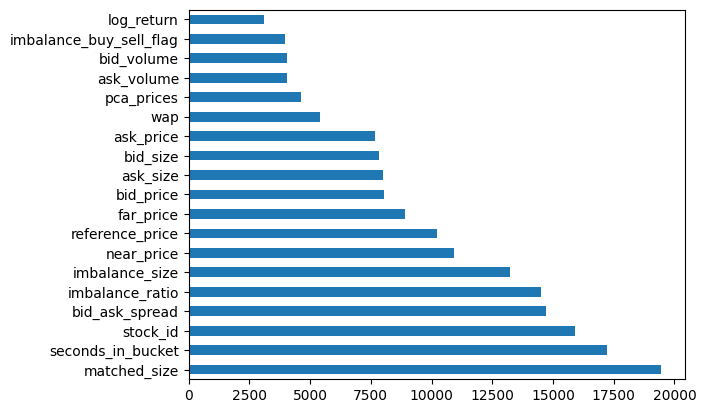

In [82]:
# feature importance
feat_imp = pd.Series(model.feature_importances_, index=X_test.columns).sort_values(ascending=False)
print(feat_imp)
feat_imp.plot(kind="barh")